In [1]:
!unzip /content/twenty+newsgroups.zip

Archive:  /content/twenty+newsgroups.zip
  inflating: 20_newsgroups.tar.gz    
  inflating: 20newsgroups.data.html  
  inflating: 20newsgroups.html       
  inflating: mini_newsgroups.tar.gz  


In [3]:
import tarfile

# open file
file = tarfile.open('/content/20_newsgroups.tar.gz')

# extracting file
file.extractall()

file.close()

In [7]:
import os
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer and stop words
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_documents(folder_path):
    documents = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            with open(file_path, 'r', errors='ignore') as f:
                documents.append(f.read())

    # Preprocess the documents
    preprocessed_documents = []
    for doc in documents:
        words = word_tokenize(doc)
        words_filtered = [lemmatizer.lemmatize(w) for w in words if w.isalpha() and w.lower() not in stop_words]
        preprocessed_documents.append(' '.join(words_filtered))

    return preprocessed_documents

# Replace 'your_folder_path' with the path to the folder containing topic folders
folder_path = '/content/20_newsgroups'
preprocessed_documents = preprocess_documents(folder_path)

# Debugging: Check the number of preprocessed documents
print(f"Number of preprocessed documents: {len(preprocessed_documents)}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Number of preprocessed documents: 19997


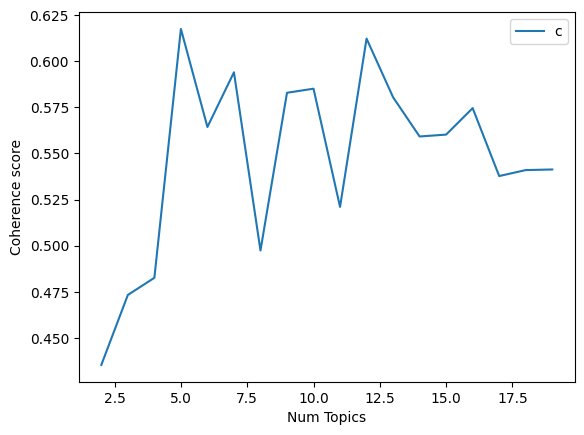

Num Topics = 2, Coherence Score = 0.4353234875093159
Num Topics = 3, Coherence Score = 0.4732746549724511
Num Topics = 4, Coherence Score = 0.4825759843626478
Num Topics = 5, Coherence Score = 0.617569881067202
Num Topics = 6, Coherence Score = 0.5643867329173432
Num Topics = 7, Coherence Score = 0.5940393102044018
Num Topics = 8, Coherence Score = 0.4973716337441538
Num Topics = 9, Coherence Score = 0.5829441770852325
Num Topics = 10, Coherence Score = 0.5851499866498013
Num Topics = 11, Coherence Score = 0.5210185789552851
Num Topics = 12, Coherence Score = 0.612318818853827
Num Topics = 13, Coherence Score = 0.5804998903773901
Num Topics = 14, Coherence Score = 0.5592290344688217
Num Topics = 15, Coherence Score = 0.5602499599107135
Num Topics = 16, Coherence Score = 0.5746058433575684
Num Topics = 17, Coherence Score = 0.5377689301787271
Num Topics = 18, Coherence Score = 0.5410014970704182
Num Topics = 19, Coherence Score = 0.5413336318497187
Optimal number of topics: 5
Topic: 0 


In [8]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

# Create a dictionary and corpus for LDA
texts = [doc.split() for doc in preprocessed_documents]
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=15, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in texts]

# Compute coherence values for different numbers of topics
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

limit = 20
start = 2
step = 1
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=texts, start=start, limit=limit, step=step)

# Show graph of coherence scores
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores for each number of topics
for m, cv in zip(x, coherence_values):
    print(f"Num Topics = {m}, Coherence Score = {cv}")

# Select the optimal number of topics (based on highest coherence score)
optimal_num_topics = x[coherence_values.index(max(coherence_values))]
print(f"Optimal number of topics: {optimal_num_topics}")

# Train the final LDA model
lda_model = LdaModel(corpus=corpus, num_topics=optimal_num_topics, id2word=dictionary, passes=15)

# Print the topics
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Convert documents to TF-IDF matrix
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(preprocessed_documents)

# Perform K-means clustering
num_clusters = optimal_num_topics  # Use the optimal number of topics from LDA
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X)

# Print the top terms per cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :10]:
        print(f" {terms[ind]}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0:
 game
 team
 player
 hockey
 year
 fan
 win
 baseball
 season
 play
Cluster 1:
 drive
 file
 card
 windows
 window
 problem
 disk
 driver
 program
 scsi
Cluster 2:
 news
 apr
 subject
 organization
 date
 gmt
 newsgroups
 path
 lines
 university
Cluster 3:
 people
 government
 gun
 right
 key
 writes
 article
 law
 fbi
 israel
Cluster 4:
 christian
 god
 jesus
 hedrick
 say
 approved
 rutgers
 morality
 people
 frank
